In [262]:
import splat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
from astropy.visualization import ZScaleInterval
import matplotlib
import wisps
import wisps.simulations as wispsim
import seaborn as sns
import matplotlib.colors as mcolors

from astropy.coordinates import SkyCoord
import astropy.coordinates as astrocoord
import astropy.units as u

import matplotlib as mpl
mpl.rcParams['font.size'] = 18
%matplotlib inline

In [263]:
#MIX MY COLORMAP WITH COOOLWARM 
colors1 = plt.cm.coolwarm(np.linspace(0., 1, 256))
colors2=plt.cm.YlOrBr(np.linspace(0., 1, 256))
colors = np.vstack((colors1+colors1)/2)
mymap=mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

In [264]:
mymap_r=mymap.reversed(name='revers')

In [265]:
def get_indices(x):
    if x is None :
        return pd.Series({})
    else:
        return  pd.Series(x.indices)
    
def get_spt(x):
    if x is None:
        return np.nan
    else:
        return x.spectral_type[0]


In [266]:
#read in the data
cands0=pd.read_hdf(wisps.LIBRARIES+'/objects_of_interest.hdf', key='all')

In [267]:
cands=cands0.spectra.apply(get_indices)
cands['spectra']=cands0.spectra

In [268]:
cands['grism_id']=cands0.grism_id
cands['spt']=cands0.spectra.apply(get_spt)

In [269]:
canddf=cands[~cands.spectra.isna()].reset_index(drop=True)

In [270]:
canddf['spt']=canddf.spectra.apply(lambda x: x.spectral_type[0])
canddf['spt_er']=canddf.spectra.apply(lambda x: x.spectral_type[1])
canddf['distance']=canddf.spectra.apply(lambda x: x.distance['val'].value)
canddf['distance_er']=canddf.spectra.apply(lambda x: x.distance['er'].value)
canddf['coord']=canddf.spectra.apply(lambda x:x.coords)
canddf['index_type']=canddf.spectra.apply(lambda x: x.index_type[0])
canddf['index_type_er']=canddf.spectra.apply(lambda x: x.index_type[1])

In [271]:
canddfj=canddf.join(canddf.spectra.apply(lambda x: pd.Series(x.mags)))
canddff=canddfj.join(canddf.spectra.apply(lambda x: pd.Series(x.snr)))
canddff['spectra']=canddf.spectra

In [272]:
ucds=wisps.Annotator.reformat_table((canddff[(canddff.spt>=17) &(canddff.snr1 >=3.)]).reset_index(drop=True)).sort_values(by='spt')

In [273]:
print (len(ucds))

184


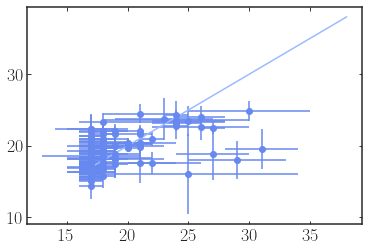

In [274]:
fig, ax=plt.subplots()
plt.errorbar(ucds['spt'], ucds['index_type'].apply(wisps.make_spt_number),
             fmt='o', xerr=ucds['spt_er'], yerr=ucds['index_type_er'])
plt.plot(ucds['spt'], ucds['spt'])

In [275]:
#remove some objects by name
ucds=(ucds[~ ucds.grism_id.isin(['par199-00124'])]).reset_index(drop=True).sort_values(by='spt')

In [276]:
coords=SkyCoord(ucds.coord.values)

In [277]:
galoc=coords.transform_to(astrocoord.Galactocentric(galcen_distance=8.3*u.kpc))

In [278]:
#Rsun=8300.
#Zsun=27.
#r=np.sqrt( (coords.distance.value * np.cos( coords.galactic.b.radian ) )**2 + Rsun * (Rsun - 2 * coords.distance.value * np.cos( coords.galactic.b.radian ) * np.cos( coords.galactic.l.radian ) ) )
#z=Zsun+ coords.distance.value * np.sin( coords.galactic.b.radian - np.arctan( Zsun / Rsun) )
x, y, z=galoc.cartesian.xyz
r=(x**2+y**2)**0.5

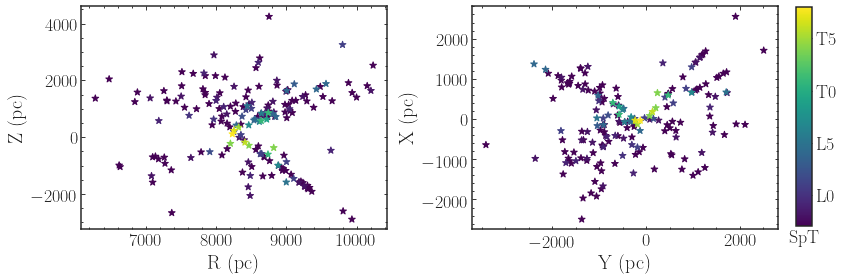

In [279]:
fig, (ax, ax1)=plt.subplots(figsize=(11, 4), ncols=2)
sc=ax.scatter(r, z, c=ucds.spt.values, s=50, cmap='viridis',  marker='*')

ax.minorticks_on()

sc=ax1.scatter(coords.cartesian.x.value, coords.cartesian.y.value, 
               c=ucds.spt.values, s=50, cmap='viridis', marker='*')


ax.minorticks_on()



ax.set_ylabel('Z (pc)', fontsize=20)
ax.set_xlabel('R (pc)', fontsize=20)
ax1.set_ylabel('X (pc)', fontsize=20)
ax1.set_xlabel('Y (pc)', fontsize=20)

ax.minorticks_on()
ax1.minorticks_on()

cax = fig.add_axes([1.01, 0.2, .02, .76])
cbar=plt.colorbar(sc, cax=cax, orientation='vertical')
cbar.ax.set_xlabel(r'SpT ', fontsize=18)
#ax.grid(which='both', color='#7FDBFF')
#ax1.grid(which='both', color='#7FDBFF')

cbar.set_ticks([20, 25, 30, 35, 40])
cbar.set_ticklabels(['L0', 'L5', 'T0', 'T5', 'Y0'])

plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/candidate_distances.pdf', bbox_inches='tight')

In [280]:
ucds['pointing']=ucds.grism_id.apply(wispsim.get_proper_pointing)

In [281]:
pntcoords=SkyCoord([x.coord for x in wisps.OBSERVED_POINTINGS 
                    if not (x.name.lower() in ucds.pointing.str.lower().values)])

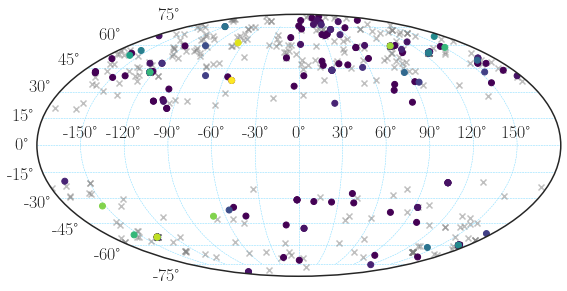

In [282]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='mollweide')

ax.scatter(pntcoords.galactic.l.wrap_at(180*u.deg).radian, pntcoords.galactic.b.wrap_at(180*u.deg).radian, c='grey', marker='x', alpha=0.5)
c=ax.scatter(galoc.galactic.l.wrap_at(180*u.deg).radian, galoc.galactic.b.wrap_at(180*u.deg).radian,
           c=np.vstack(ucds.spt.values)[:,0], cmap='viridis')


#plt.xlabel("l", fontsize=18)
#plt.ylabel("b", fontsize=18)
plt.grid(color='#7FDBFF')
plt.minorticks_on()
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/candidate_skymap.pdf', bbox_inches='tight')

In [283]:
fdf=ucds.sort_values(by='spt')[['grism_id', 'distance', 'spt','spectra']]

In [284]:
latc_df=pd.DataFrame()

In [285]:
latc_df['Shortname']=fdf.spectra.apply(lambda x: x.shortname.upper())
latc_df['designation']=fdf.spectra.apply(lambda x: x.designation.upper())
latc_df['grism id']=fdf.spectra.apply(lambda x: x.name.upper())
latc_df['snrj']=fdf.spectra.apply(lambda x: int(round(x.snr['snr1'])))
latc_df['spt']=fdf.spectra.apply(lambda x: splat.typeToNum(x.spectral_type[0]) +r'$\pm$'+ str(x.spectral_type[1]))
latc_df['ra']=fdf.spectra.apply(lambda x: x.ra.value)
latc_df['dec']=fdf.spectra.apply(lambda x: x.dec.value)
latc_df['f110']=fdf.spectra.apply(lambda x:  str(round(x.mags['F110W'][0],3)) +r'$\pm$'+ str(round(x.mags['F110W'][1],3)))
#latc_df['f110_er']=fdf.spectra.apply(lambda x: round(x.mags['F110W'][1], 1))
latc_df['f140']=fdf.spectra.apply(lambda x:  str(round(x.mags['F140W'][0],3)) +r'$\pm$'+  str(round(x.mags['F140W'][1],3)))
#latc_df['f140_er']=fdf.spectra.apply(lambda x: round(x.mags['F140W'][1], 1))
latc_df['f160']=fdf.spectra.apply(lambda x:   str(round(x.mags['F160W'][0],3)) + r'$\pm$'+ str(round(x.mags['F160W'][1],3)))
#latc_df['f160_er']=fdf.spectra.apply(lambda x: round(x.mags['F160W'][1], 1))
latc_df['distance']=fdf.spectra.apply(lambda x: str(int(round(x.distance['val'].value, 0)))  + r'$\pm$'+ 
                                                 str((int(round(x.distance['er'].value, 0)))))

In [286]:
latc_df=latc_df.replace('nan$\\pm$nan', 'nodata')

In [287]:
#get the right sequence of coplumns
col_list=['designation','grism id', 'ra', 'dec', 'f110', 'f140', 'f160', 'snrj', 'spt', 'distance']

In [288]:
latc_df[col_list].to_latex(wisps.LIBRARIES+'/candidates.tex',
             header=True, index=False, na_rep=' ')

In [289]:
fdf=fdf.reset_index(drop=True)

#########################

In [290]:
spdwarf=splat.searchLibrary(binary=False, giant=False, ucd=True)
spdwarf.shortname=spdwarf.DESIGNATION.apply(splat.designationToShortName)
spdwarf=spdwarf[~(spdwarf.shortname.isin(wisps.FORBIDDEN_LIST) )]
#spdwarf=spdwarf[~spdwarf.]
spdwarf.SPEX_TYPE=spdwarf.SPEX_TYPE.apply(wisps.make_spt_number)

In [291]:
def format_jk_zhang(row):
    jmag=np.nan
    hmag=np.nan
    jmag_er=np.nan
    hmag_er=np.nan
    if row['J'] !='none':
        #print ((row['J']).split('±'))
        #row['J_mag']=(row['J']).split('±')[0]
        #row['J_er']=(row['J']).split('±')[-1]
        jmag=(row['J']).split('±')[0]
        jmag_er=(row['J']).split('±')[1]
        
    if row['H'] !='none':
        #print ((row['H']).split('±'))
        #row['H_mag']=(row['H']).split('±')[0]
        #row['H_er']=(row['H']).split('±')[-1]
        hmag=(row['H']).split('±')[0]
        hmag_er=(row['H']).split('±')[1]
        
    spt=splat.typeToNum(row[' SpT'])
        
    return pd.Series({'H':jmag, 'J':hmag, 'H_er':hmag_er, 'J_er':jmag_er, 'SpTn':spt})

def format_jk_manj(row):
    jmag=np.nan
    hmag=np.nan
    jmag_er=np.nan
    hmag_er=np.nan
    if str(row['J (mag)']) !='nan':
        #ignore others
        if not str(row['J (mag)']).startswith('>'):
            jmag=((row['J (mag)']).split('+or-')[0]).strip()
            jmag_er=((row['J (mag)']).split('+or-')[1]).strip()

    if str(row['H (mag)']) !='nan':
        if not str(row['J (mag)']).startswith('>'):
            hmag=(row['H (mag)']).split('+or-')[0]
            hmag_er=(row['H (mag)']).split('+or-')[1]
        
    spt=splat.typeToNum(row['SpT'])
        
    return pd.Series({'H':jmag, 'J':hmag, 'H_er':hmag_er, 'J_er':jmag_er, 'SpTn':spt})

In [292]:
fdf=ucds
pols=wisps.POLYNOMIAL_RELATIONS
color_pol=pols['colors']

In [293]:
#zhang
zhng=pd.read_csv('~/research/wisps/data/zhang_data.csv')
zhng_clrs=zhng.apply(format_jk_zhang, axis=1 ).applymap(float)

In [294]:
#manjavacas
man_df0=pd.read_csv('/users/caganze/research/wisps/data/manjavaca_phot.txt', sep='\t',  index_col=None)
man_clrs=man_df0.apply(format_jk_manj, axis=1 ).applymap(float)

In [295]:
man_clrs.columns

Index(['H', 'J', 'H_er', 'J_er', 'SpTn'], dtype='object')

In [296]:
fdf['J']=fdf['F140W']+color_pol['j_f140'][0](fdf['spt'])
fdf['J_er']=(fdf['F140W_er']**2+color_pol['j_f140'][1]**2)**0.5

fdf['H']=fdf['F160W']+color_pol['h_f160'][0](fdf['spt'])
fdf['H_er']=(fdf['F160W_er']**2+color_pol['h_f160'][1]**2)**0.5

In [297]:
fdf['J_110']=fdf['F110W']+color_pol['j_f110'][0](fdf['spt'])
fdf['J_110_er']=(fdf['F110W_er']**2+color_pol['j_f110'][1]**2)**0.5

In [298]:
ucd_wisp=fdf[fdf.grism_id.str.startswith('par')]
ucd_hst3d=fdf[~fdf.grism_id.str.startswith('par')]

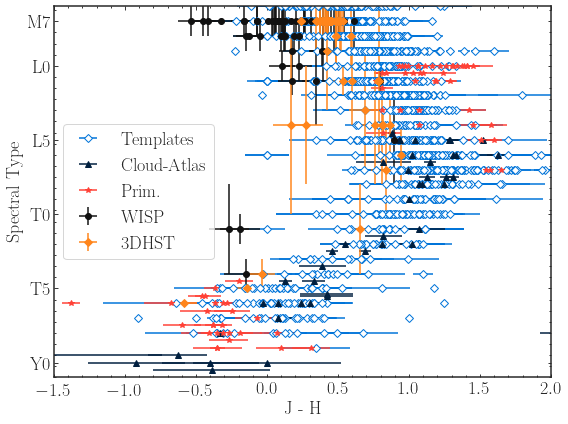

In [299]:
fig, ax=plt.subplots(figsize=(8, 6))



ax.errorbar(spdwarf['J_2MASS']-spdwarf['H_2MASS'], spdwarf.SPEX_TYPE, fmt='D', 
            xerr=(spdwarf.J_2MASS_E**2+spdwarf.H_2MASS_E**2)**0.5, color='#0074D9', 
            mfc='white',  label='Templates')

#ax.errorbar(spsubdwarf['J_2MASS']-spsubdwarf['H_2MASS'],spsubdwarf.SPEX_TYPE, fmt='D', 
#            xerr=(spsubdwarf.J_2MASS_E**2+spsubdwarf.H_2MASS_E**2)**0.5, color='#2ECC40', mfc='white', label='Spex Subdwarfs')

ax.errorbar(-man_clrs['J']+man_clrs['H'], man_clrs['SpTn'], fmt='^', 
            xerr=(man_clrs['J_er']**2+man_clrs['H_er']**2)**0.5, color='#001f3f', label='Cloud-Atlas')

ax.errorbar(-zhng_clrs['J']+zhng_clrs['H'],zhng_clrs.SpTn, fmt='*', 
            xerr=(zhng_clrs.J_er**2+zhng_clrs.H_er**2)**0.5, color='#FF4136', label='Prim.')



ax.errorbar(ucd_wisp['J_110']-ucd_wisp['H'], ucd_wisp['spt'], fmt='o', 
            xerr=(ucd_wisp['J_110_er']**2+ucd_wisp['H_er']**2)**0.5, 
            yerr=ucd_wisp['spt_er'], color='#111111', label=r'WISP')

ax.errorbar(ucd_hst3d['J']-ucd_hst3d['H'], ucd_hst3d['spt'], fmt='D',
            xerr=(ucd_hst3d['J_er']**2+ucd_hst3d['H_er']**2)**0.5, 
            yerr=ucd_hst3d['spt_er'], color='#FF851B', label=r'3DHST')


ax.set_ylim([16, 41])
ax.set_xlim([-1.5, 2])
ax.invert_yaxis()


ax.set_yticks([17, 20, 25, 30, 35, 40])
ax.set_yticklabels(['M7', 'L0', 'L5', 'T0', 'T5', 'Y0'])


ax.minorticks_on()
ax.set_ylabel('Spectral Type', fontsize=18)
ax.set_xlabel(r'J - H', fontsize=18)

ax.legend(fontsize=18)

#plt.grid(which='both', color='#7FDBFF')
plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/color_color_plots.pdf', bbox_inches='tight')


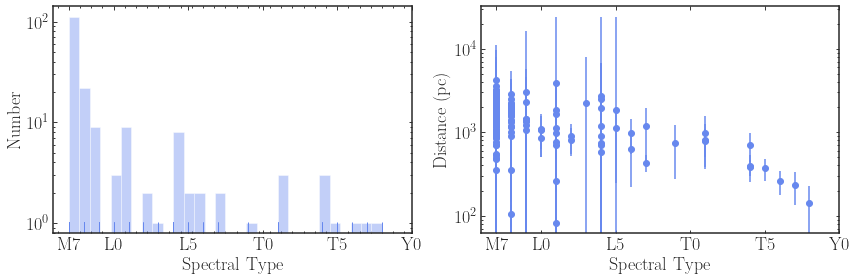

In [300]:
fig, (ax, ax1)=plt.subplots(ncols=2, figsize=(12, 4))
sns.distplot(ucds.spt, kde=False, ax=ax, rug=True)
ax.set_yscale('log')
plt.tight_layout()
ax.set_xlabel('Spectral Type', fontsize=18)
ax.set_ylabel('Number', fontsize=18)
ax.minorticks_on()

ax1.errorbar(ucds.spt,  ucds.distance, yerr=ucds.distance_er , fmt='o')
ax1.set_yscale('log')
ax1.set_ylabel('Distance (pc)', fontsize=18)
ax1.set_xlabel('Spectral Type', fontsize=18)

for a in [ax, ax1]:
    a.set_xticks([17, 20, 25, 30, 35, 40])
    a.set_xticklabels(['M7', 'L0', 'L5', 'T0', 'T5', 'Y0'])

plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/sptdistribution.pdf',  bbox_inches='tight')

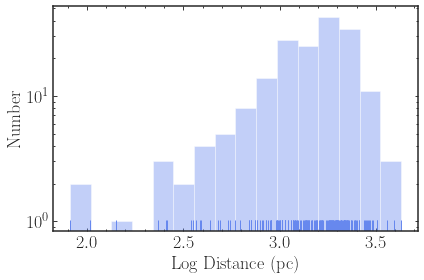

In [301]:
fig,ax=plt.subplots()
sns.distplot(ucds.distance.apply(np.log10), kde=False, ax=ax, rug=True)
ax.set_yscale('log')
plt.tight_layout()
ax.set_xlabel('Log Distance (pc)', fontsize=18)
ax.set_ylabel('Number', fontsize=18)
ax.minorticks_on()
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/distdistribution.pdf',  bbox_inches='tight')

In [302]:
ldwarfs=(fdf.sort_values('spt').spectra[fdf.spt.between(20, 30)]).reset_index(drop=True)
tdwarfs=(fdf.sort_values('spt').spectra[fdf.spt.between(30, 40)]).reset_index(drop=True)

In [303]:
import seaborn as sns
sns.set_palette('coolwarm')

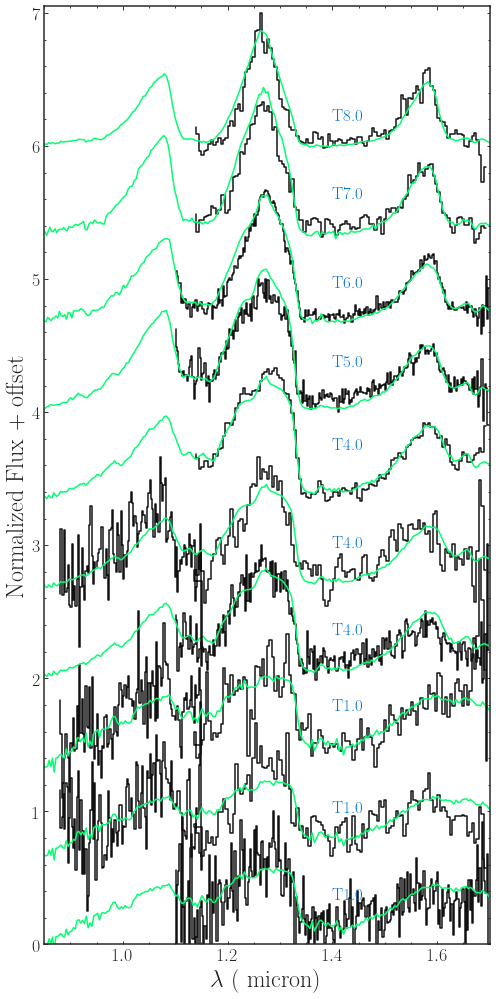

In [304]:
fig, ax=plt.subplots(figsize=(7, 14))

for  idx, y in enumerate(tdwarfs):
    x=y.splat_spectrum
    
    if x.wave.value.min()< 0.9:
        x.trim([0.88, 1.7])
        
    if x.wave.value.min()>0.9:
        x.trim([1.1, 1.7])
  
    std= splat.STDS_DWARF_SPEX[splat.typeToNum(y.spectral_type[0])]
    
    std.normalize(waverange=[1.15, 1.65])
    x.normalize(waverange=[1.15, 1.65])
    

    
    med0=(x.flux.value[np.logical_and(x.wave.value >1.15, x.wave.value <1.65) ]).mean()
    med1=(std.flux.value[np.logical_and(std.wave.value >1.15, std.wave.value <1.65) ]).mean()
    
    std.scale(med0/med1)
    
    plt.text(1.4, (x.flux.value+idx/1.5).mean(),splat.typeToNum(y.spectral_type[0]),
             {'fontsize':17, 'weight': 'bold'}, color='#0074D9')
    
    
    plt.step(x.wave.value, x.flux.value+idx/1.5, c='#111111')
    plt.plot(std.wave.value, std.flux.value+ idx/1.5, c='#01FF70')
    plt.ylim([0., 7.05])
    plt.xlim([0.85, 1.7])
    
plt.minorticks_on()
 

ax.set_xlabel(r'$\lambda$ ( micron)', fontsize=24)
ax.set_ylabel(r'Normalized Flux + offset', fontsize=24)

plt.tight_layout()  

plt.savefig(wisps.OUTPUT_FIGURES+'/tdwarfsequence.pdf')

In [305]:
len(ldwarfs)

30

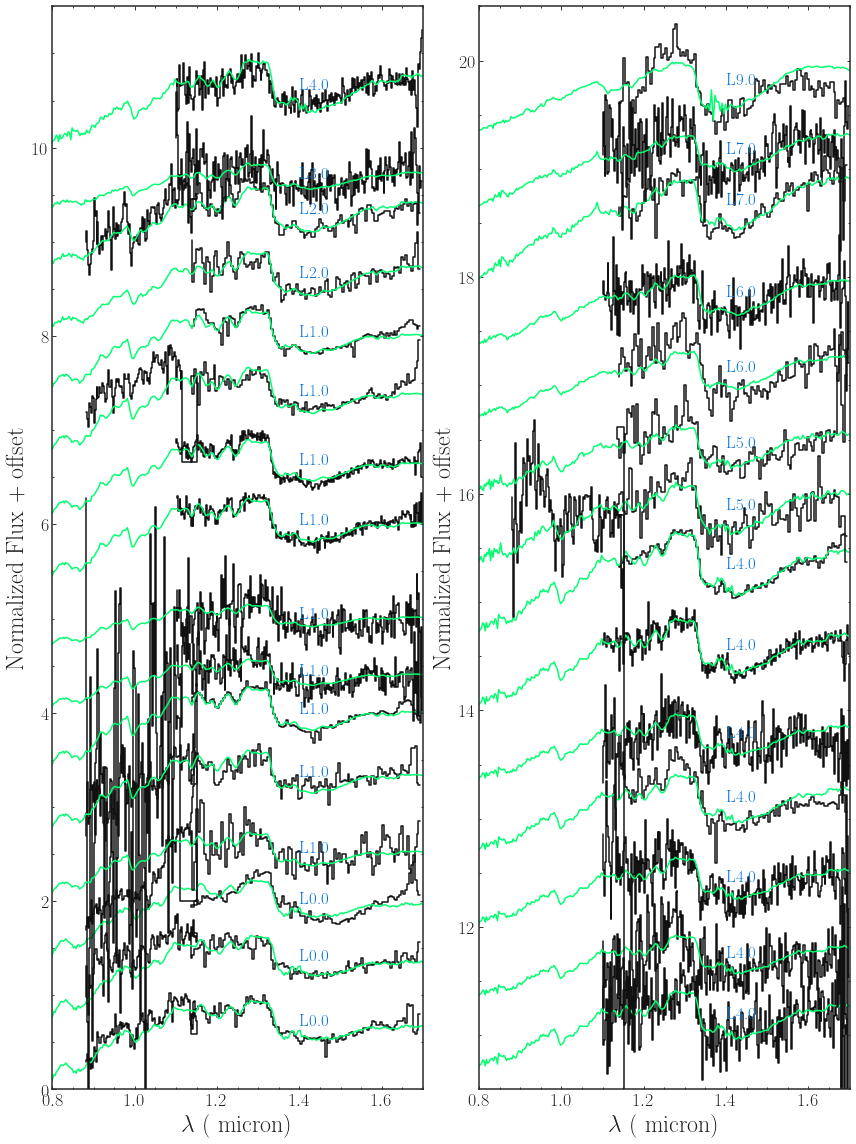

In [306]:
fig, ax=plt.subplots(figsize=(12, 16), ncols=2, sharey=False)

s=0
for  idx, y in enumerate(ldwarfs):
    a=ax[0]
    
    if idx>15:
        a=ax[1]
    
    x=y.splat_spectrum
    
    if x.wave.value.min()< 0.9:
        x.trim([0.88, 1.7])
        
    if x.wave.value.min()>0.9:
        x.trim([1.1, 1.7])
    
    std= splat.STDS_DWARF_SPEX[splat.typeToNum(y.spectral_type[0])]
    
    std.normalize(waverange=[1.2, 1.6])
    x.normalize(waverange=[1.2, 1.6])
    
    med0=(x.flux.value[np.logical_and(x.wave.value >1.2, x.wave.value <1.6) ]).mean()
    med1=(std.flux.value[np.logical_and(std.wave.value >1.2, std.wave.value <1.6) ]).mean()
    
    std.scale(med0/med1)

    
    a.text(1.4, med0+idx/1.5,splat.typeToNum(y.spectral_type[0]),
             {'fontsize':17, 'weight': 'bold'}, color='#0074D9')
    
    
    a.step(x.wave.value, x.flux.value+idx/1.5, c='#111111')
    a.plot(std.wave.value, std.flux.value+idx/1.5, c='#01FF70')
    
    a.minorticks_on()
    a.set_xlabel(r'$\lambda$ ( micron)', fontsize=24)
    a.set_ylabel(r'Normalized Flux + offset', fontsize=24)
    
    
    s=s+1
    
    
    
plt.minorticks_on()
 

    
ax[0].set_ylim([0.,11.5])
ax[0].set_xlim([0.8, 1.7])

ax[1].set_ylim([10.5, 20.5])
ax[1].set_xlim([0.8, 1.7])

plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/ldwarfsequence.pdf')

In [316]:
ucds['f_test']=ucds.spectra.apply(lambda x: x.f_test)
ucds['dof']=ucds.spectra.apply(lambda x: x.dof)
ucds['line_chi']=ucds.spectra.apply(lambda x: x.line_chi)
ucds['spex_chi']=ucds.spectra.apply(lambda x: x.spex_chi)

(array([17., 28., 40., 50., 35.,  7.,  5.,  0.,  0.,  0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

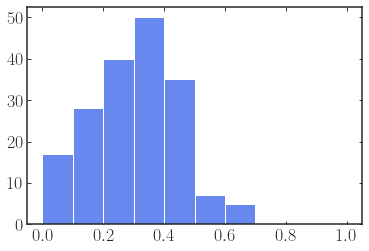

In [323]:
plt.hist(ucds.spex_chi/ucds.line_chi, range=[0, 1])

In [309]:
#%%capture
'''
fold='/Users/caganze/research/wisps/figures/ltwarfs/'
ids=0
for idx, row in fdf.iterrows():
    try:
        s=row.spectra
        filename=fold+'spectrum'+str(ids)+'.pdf'
        s.pixels_per_image=100
        s.plot(save=True, filename=filename)
        ids=ids+1
    except:
        s=wisps.Source(filename=row.grism_id.replace('g141', 'G141'),is_ucd=False )
        s.pixels_per_image=100
        filename=fold+'spectrum'+str(ids)+'.pdf'
        s.plot(save=True, filename=filename)
        ids=ids+1
'''

"\nfold='/Users/caganze/research/wisps/figures/ltwarfs/'\nids=0\nfor idx, row in fdf.iterrows():\n    try:\n        s=row.spectra\n        filename=fold+'spectrum'+str(ids)+'.pdf'\n        s.pixels_per_image=100\n        s.plot(save=True, filename=filename)\n        ids=ids+1\n    except:\n        s=wisps.Source(filename=row.grism_id.replace('g141', 'G141'),is_ucd=False )\n        s.pixels_per_image=100\n        filename=fold+'spectrum'+str(ids)+'.pdf'\n        s.plot(save=True, filename=filename)\n        ids=ids+1\n"